# H3K27ac extra

In [103]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import pandas as pd
import seaborn as sns
from IPython.display import display
from tqdm.auto import tqdm

sns.set_style("whitegrid")
import matplotlib.pyplot as plt
import numpy as np
import os
import pyBigWig
import tempfile
from itertools import product

In [104]:
def bedl(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return tf[2] - tf[1]
    except:
        return np.zeros(0)  # Empty file


def lines(file):
    try:
        tf = pd.read_csv(file, sep='\t', header=None)
        return len(tf)
    except:
        return 0  # Empty file


def d(a, b):
    return a / b if b != 0 else 0

def last_col(file):
    try:
        cols = len(pd.read_csv(file, sep='\t', nrows=1, header=None).columns)
        return pd.read_csv(file, sep='\t', header=None, usecols=[cols - 1])[cols - 1]
    except:
        return np.zeros(0)  # Empty file

def sorted_file(file):
    ts = tempfile.mktemp()
    !cat {file} | sort -k1,1 -k2,2n > {ts}
    return ts

# Load hg38 peaks


In [105]:
GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320')
# GSE26320_PATH_HG38 = os.path.expanduser('~/data/2023_GSE26320_no_control')
GSE26320_CELLS = ['GM12878', 'HMEC', 'HSMM', 'K562', 'NHEK', 'NHLF', 'H1', 'Huvec', 'HepG2']
# GSE26320_CELLS = ['GM12878',  'K562', 'H1']
# GSE26320_MODIFICATIONS = ['CTCF', 'H3K27ac', 'H3K27me3', 'H3K36me3', 'H3K4me1', 'H3K4me2', 'H3K4me3', 'H3K9ac', 'H4K20me1']
GSE26320_MODIFICATIONS = ['H3K27ac']
GSE26320_REPS = ['rep1', 'rep2']

! mkdir -p {GSE26320_PATH_HG38}/pics

In [106]:
def load_peaks_fdr(path, suffix, fdrs):
    df_fdr = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate', 'fdr', 'peaks', 'avlength'],
                          dtype=object)
    for f in tqdm(os.listdir(path)):
        if suffix not in f:
            continue
        fdr = next((fdr for fdr in fdrs if fdr in f), None)
        cell = next((cc for cc in GSE26320_CELLS if cc in f), None)
        mod = next((m for m in GSE26320_MODIFICATIONS if m in f), None)
        rep = next((r for r in GSE26320_REPS if r in f), None)
        if fdr and cell and rep and mod:
            peaks_path = os.path.join(path, f)
            ps, ls = lines(peaks_path), bedl(peaks_path)
            avls = 0 if ps == 0 else sum(ls) / ps
            df_fdr.loc[len(df_fdr)] = (peaks_path, mod, cell, rep, fdr, ps, avls)
    return df_fdr

In [110]:
df_fdr_macs2 = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'macs2'), '.narrowPeak', ['0.05'])
df_fdr_macs2['tool'] = 'MACS2'
print('MACS2', len(df_fdr_macs2))

df_fdr_macs2broad = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'macs2'), '.broadPeak', ['0.1'])
df_fdr_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_fdr_macs2broad))

df_fdr_sicer = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'sicer'), 'summary-FDR', ['0.01'])
# df_fdr_sicer = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'sicer'), '.scoreisland', ['0.01'])
df_fdr_sicer['tool'] = 'SICER'
print('SICER', len(df_fdr_sicer))

df_fdr_span = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'span'), '.peak', ['0.05'])
df_fdr_span['tool'] = 'SPAN'
print('SPAN', len(df_fdr_span))

TOOLS = ['MACS2', 'MACS2 broad', 'SICER', 'SPAN']
df_fdr_peaks = pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span])
df_fdr_peaks.sample(5)

  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 17


  0%|          | 0/680 [00:00<?, ?it/s]

MACS2 broad 17


  0%|          | 0/251 [00:00<?, ?it/s]

SICER 17


  0%|          | 0/88 [00:00<?, ?it/s]

SPAN 17


,file,modification,cell,replicate,fdr,peaks,avlength,tool
3,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K27ac,K562,rep2,0.01,26159,2982.355633,SICER
5,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K27ac,NHLF,rep2,0.05,36440,1850.276811,SPAN
16,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,HepG2,rep1,0.1,32654,2070.666779,MACS2 broad
1,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,GM12878,rep2,0.05,43917,867.432133,MACS2
11,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K27ac,K562,rep2,0.05,20535,1981.237351,SPAN


In [111]:
TOOLS = ['MACS2', 'MACS2 broad', 'SPAN', 'SICER']
palette = plt.cm.get_cmap('tab10')
TOOLS_PALETTE = {t: palette(i) for i, t in enumerate(TOOLS)}

# Update peaks to contain only percentile only

In [112]:
# df_fdr_peaks.drop(['avlength'], axis=1, inplace=True)
df_fdr_peaks['original_file'] = df_fdr_peaks['file']

step = 20
for percentage in [0, 20, 40, 60, 80]:
    percentage_name = f'{percentage}%-{percentage + step}%'
    ! mkdir -p {GSE26320_PATH_HG38}/percentiles/{percentage_name}
    print(percentage_name)
    percentile_files = []
    for file, cell, replicate in tqdm(zip(df_fdr_peaks['file'], df_fdr_peaks['cell'], df_fdr_peaks['replicate'])):
        union_path = f'{GSE26320_PATH_HG38}/union/H3K27ac_{cell}_{replicate}.bed'
        t = pd.read_csv(union_path, sep='\t', header=None, usecols=[0, 1, 2])
        t[3] = t[2] - t[1]
        t.sort_values(by=[3, 0, 1, 2], inplace=True)
    
        pf = f'{GSE26320_PATH_HG38}/percentiles/{percentage_name}_H3K27ac_{cell}_{replicate}.bed'
        # Take % peaks by lengths and compute ratios inside
        t.iloc[int(len(t) * percentage / 100):int(len(t) * (percentage + step) / 100)][[0, 1, 2]].to_csv(
            pf, sep='\t', index=False, header=None
        )
        # Prepare percentage
        file_perc = f'{GSE26320_PATH_HG38}/percentiles/{percentage_name}/{os.path.basename(file)}' 
        print(percentage_name, cell, replicate, file_perc)
        ! bedtools intersect -wa -u -a {sorted_file(file)} -b {sorted_file(pf)} > {file_perc}
        percentile_files.append(file_perc)
    df_fdr_peaks[percentage_name] = percentile_files

df_fdr_peaks.sample(5)

0%-20%


0it [00:00, ?it/s]

0%-20% HepG2 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646356_HepG2_H3K27ac_rep2_q0.05_peaks.narrowPeak
0%-20% GM12878 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646317_GM12878_H3K27ac_rep2_q0.05_peaks.narrowPeak
0%-20% H1 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646336_H1_H3K27ac_rep1_q0.05_peaks.narrowPeak
0%-20% NHLF rep2 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646477_NHLF_H3K27ac_rep2_q0.05_peaks.narrowPeak
0%-20% HepG2 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646355_HepG2_H3K27ac_rep1_q0.05_peaks.narrowPeak
0%-20% K562 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646434_K562_H3K27ac_rep1_q0.05_peaks.narrowPeak
0%-20% HSMM rep2 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646395_HSMM_H3K27ac_rep2_q0.05_peaks.narrowPeak
0%-20% Huvec rep1 /home/jetbrains/data/2023_GSE26320/percentiles/0%-20%/GSM646414_Huvec_H3K27ac_rep1_q0.05_peaks.narrowPeak
0%-20% HSMM rep1

0it [00:00, ?it/s]

20%-40% HepG2 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646356_HepG2_H3K27ac_rep2_q0.05_peaks.narrowPeak
20%-40% GM12878 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646317_GM12878_H3K27ac_rep2_q0.05_peaks.narrowPeak
20%-40% H1 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646336_H1_H3K27ac_rep1_q0.05_peaks.narrowPeak
20%-40% NHLF rep2 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646477_NHLF_H3K27ac_rep2_q0.05_peaks.narrowPeak
20%-40% HepG2 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646355_HepG2_H3K27ac_rep1_q0.05_peaks.narrowPeak
20%-40% K562 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646434_K562_H3K27ac_rep1_q0.05_peaks.narrowPeak
20%-40% HSMM rep2 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646395_HSMM_H3K27ac_rep2_q0.05_peaks.narrowPeak
20%-40% Huvec rep1 /home/jetbrains/data/2023_GSE26320/percentiles/20%-40%/GSM646414_Huvec_H3K27ac_rep1_q0.05_peaks.narrowPeak


0it [00:00, ?it/s]

40%-60% HepG2 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646356_HepG2_H3K27ac_rep2_q0.05_peaks.narrowPeak
40%-60% GM12878 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646317_GM12878_H3K27ac_rep2_q0.05_peaks.narrowPeak
40%-60% H1 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646336_H1_H3K27ac_rep1_q0.05_peaks.narrowPeak
40%-60% NHLF rep2 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646477_NHLF_H3K27ac_rep2_q0.05_peaks.narrowPeak
40%-60% HepG2 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646355_HepG2_H3K27ac_rep1_q0.05_peaks.narrowPeak
40%-60% K562 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646434_K562_H3K27ac_rep1_q0.05_peaks.narrowPeak
40%-60% HSMM rep2 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646395_HSMM_H3K27ac_rep2_q0.05_peaks.narrowPeak
40%-60% Huvec rep1 /home/jetbrains/data/2023_GSE26320/percentiles/40%-60%/GSM646414_Huvec_H3K27ac_rep1_q0.05_peaks.narrowPeak


0it [00:00, ?it/s]

60%-80% HepG2 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646356_HepG2_H3K27ac_rep2_q0.05_peaks.narrowPeak
60%-80% GM12878 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646317_GM12878_H3K27ac_rep2_q0.05_peaks.narrowPeak
60%-80% H1 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646336_H1_H3K27ac_rep1_q0.05_peaks.narrowPeak
60%-80% NHLF rep2 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646477_NHLF_H3K27ac_rep2_q0.05_peaks.narrowPeak
60%-80% HepG2 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646355_HepG2_H3K27ac_rep1_q0.05_peaks.narrowPeak
60%-80% K562 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646434_K562_H3K27ac_rep1_q0.05_peaks.narrowPeak
60%-80% HSMM rep2 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646395_HSMM_H3K27ac_rep2_q0.05_peaks.narrowPeak
60%-80% Huvec rep1 /home/jetbrains/data/2023_GSE26320/percentiles/60%-80%/GSM646414_Huvec_H3K27ac_rep1_q0.05_peaks.narrowPeak


0it [00:00, ?it/s]

80%-100% HepG2 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646356_HepG2_H3K27ac_rep2_q0.05_peaks.narrowPeak
80%-100% GM12878 rep2 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646317_GM12878_H3K27ac_rep2_q0.05_peaks.narrowPeak
80%-100% H1 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646336_H1_H3K27ac_rep1_q0.05_peaks.narrowPeak
80%-100% NHLF rep2 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646477_NHLF_H3K27ac_rep2_q0.05_peaks.narrowPeak
80%-100% HepG2 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646355_HepG2_H3K27ac_rep1_q0.05_peaks.narrowPeak
80%-100% K562 rep1 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646434_K562_H3K27ac_rep1_q0.05_peaks.narrowPeak
80%-100% HSMM rep2 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646395_HSMM_H3K27ac_rep2_q0.05_peaks.narrowPeak
80%-100% Huvec rep1 /home/jetbrains/data/2023_GSE26320/percentiles/80%-100%/GSM646414_Huvec_H3K27ac_rep1_q0.05_p

,file,modification,cell,replicate,fdr,peaks,avlength,tool,original_file,0%-20%,20%-40%,40%-60%,60%-80%,80%-100%
8,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,H3K27ac,HSMM,rep1,0.05,57283,790.006704,MACS2,/home/jetbrains/data/2023_GSE26320/macs2/GSM64...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...
10,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K27ac,HMEC,rep1,0.05,47858,1718.425822,SPAN,/home/jetbrains/data/2023_GSE26320/span/GSM646...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...
1,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K27ac,HSMM,rep1,0.05,38858,1544.996088,SPAN,/home/jetbrains/data/2023_GSE26320/span/GSM646...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...
12,/home/jetbrains/data/2023_GSE26320/span/GSM646...,H3K27ac,NHEK,rep1,0.05,48853,1713.995640,SPAN,/home/jetbrains/data/2023_GSE26320/span/GSM646...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...
15,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,H3K27ac,HMEC,rep1,0.01,36689,3985.437352,SICER,/home/jetbrains/data/2023_GSE26320/sicer/GSM64...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...,/home/jetbrains/data/2023_GSE26320/percentiles...


In [113]:
df_fdr_peaks['file'] = df_fdr_peaks['80%-100%']
# df_fdr_peaks['file'] = df_fdr_peaks['0%-20%']
# df_fdr_peaks['file'] = df_fdr_peaks['40%-60%']

# Coverage

In [114]:
# Fraction of reads in peaks
GSE26320_PATH_HG38_BW = GSE26320_PATH_HG38 + '/bw'


def load_bws(path, m):
    df_bws = pd.DataFrame(columns=['file', 'modification', 'cell', 'replicate'], dtype=object)
    for f in tqdm(os.listdir(path)):
        if '.bw' not in f:
            continue
        cell = next((cc for cc in GSE26320_CELLS if cc in f), None)
        rep = next((r for r in GSE26320_REPS if r in f), None)
        if cell and rep and m in f:
            df_bws.loc[len(df_bws)] = ((os.path.join(path, f)), m, cell, rep)
    return df_bws

In [115]:
bws_df = load_bws(GSE26320_PATH_HG38_BW, 'H3K27ac')
display(bws_df.sample(3))
bws_control_df = load_bws(GSE26320_PATH_HG38_BW, 'Input')
display(bws_control_df.sample(3))

  0%|          | 0/103 [00:00<?, ?it/s]

,file,modification,cell,replicate
9,/home/jetbrains/data/2023_GSE26320/bw/GSM64643...,H3K27ac,K562,rep1
16,/home/jetbrains/data/2023_GSE26320/bw/GSM64631...,H3K27ac,GM12878,rep1
8,/home/jetbrains/data/2023_GSE26320/bw/GSM64633...,H3K27ac,H1,rep1


  0%|          | 0/103 [00:00<?, ?it/s]

,file,modification,cell,replicate
8,/home/jetbrains/data/2023_GSE26320/bw/GSM64639...,Input,HMEC,rep1
3,/home/jetbrains/data/2023_GSE26320/bw/GSM64643...,Input,Huvec,rep2
14,/home/jetbrains/data/2023_GSE26320/bw/GSM64643...,Input,Huvec,rep1


In [116]:
CHROM_SIZES = {
    c: s for _, (c, s) in pd.read_csv(os.path.join(GSE26320_PATH_HG38, 'hg38.chrom.sizes'),
                                      sep='\t', names=['chr', 'size']).iterrows() if '_' not in c
}
CHROM_SIZES

{'chr1': 248956422,
 'chr2': 242193529,
 'chr3': 198295559,
 'chr4': 190214555,
 'chr5': 181538259,
 'chr6': 170805979,
 'chr7': 159345973,
 'chrX': 156040895,
 'chr8': 145138636,
 'chr9': 138394717,
 'chr11': 135086622,
 'chr10': 133797422,
 'chr12': 133275309,
 'chr13': 114364328,
 'chr14': 107043718,
 'chr15': 101991189,
 'chr16': 90338345,
 'chr17': 83257441,
 'chr18': 80373285,
 'chr20': 64444167,
 'chr19': 58617616,
 'chrY': 57227415,
 'chr22': 50818468,
 'chr21': 46709983,
 'chrM': 16569}

## FRIP

In [117]:
import pyBigWig

tf = tempfile.mktemp()

frip_df = pd.DataFrame(
    columns=['cell', 'replicate', 'bw_file', 'tool', 'peaks_file', 'peaks', 'length',
             'reads_in_peaks', 'all_reads', 'control_reads_in_peaks', 'control_all_reads'],
    dtype=object
)

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    # for c, r in tqdm(product(['GM12878'], ['rep1'])):
    print(c, r)
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) & (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c) & (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        peaks = lines(peaks_file)
        if peaks == 0:
            continue
        peaks_len = int(bedl(peaks_file).sum())
        t = bws_df[(bws_df['modification'] == 'H3K27ac') &
                   (bws_df['cell'] == c) & (bws_df['replicate'] == r)]
        if len(t) == 0:
            continue
        bw_file = t['file'].values[0]
        t = bws_control_df[(bws_control_df['cell'] == c) & (bws_control_df['replicate'] == r)]
        if len(t) == 0:
            continue
        bw_control_file = t['file'].values[0]

        print(tool, peaks_file, bw_file, bw_control_file)
        t = pd.read_csv(peaks_file, sep='\t', header=None)
        with pyBigWig.open(bw_file) as bw:
            total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
            peaks_coverage = sum(bw.stats(chr, start, end, type='sum', exact=True)[0]
                                 for chr, start, end in zip(t[0], t[1], t[2]))
        with pyBigWig.open(bw_control_file) as bwc:
            control_total_coverage = sum(
                bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
            control_peaks_coverage = sum(bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                         for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES)
        frip_df.loc[len(frip_df)] = (c, r, bw_file, tool, peaks_file, peaks, peaks_len,
                                     peaks_coverage, total_coverage, control_peaks_coverage, control_total_coverage)

frip_df

0it [00:00, ?it/s]

GM12878 rep1
MACS2 broad /tmp/tmp82odye6j /home/jetbrains/data/2023_GSE26320/bw/GSM646316_GM12878_H3K27ac_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
SICER /tmp/tmp9hp7533u /home/jetbrains/data/2023_GSE26320/bw/GSM646316_GM12878_H3K27ac_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
MACS2 /tmp/tmputcfvfuq /home/jetbrains/data/2023_GSE26320/bw/GSM646316_GM12878_H3K27ac_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
SPAN /tmp/tmp1kx60sc0 /home/jetbrains/data/2023_GSE26320/bw/GSM646316_GM12878_H3K27ac_rep1.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646332_GM12878_Input_rep1.bw
GM12878 rep2
MACS2 broad /tmp/tmpe0msitcn /home/jetbrains/data/2023_GSE26320/bw/GSM646317_GM12878_H3K27ac_rep2.bw /home/jetbrains/data/2023_GSE26320/bw/GSM646333_GM12878_Input_rep2.bw
SICER /tmp/tmp4rc2_rcf /home/jetbrains/data/2023_GSE26320/bw/GSM646317_GM12878_H3K27ac_rep2.bw /home/jetbrains/data/2023_GSE26320/bw/GSM64

,cell,replicate,bw_file,tool,peaks_file,peaks,length,reads_in_peaks,all_reads,control_reads_in_peaks,control_all_reads
0,GM12878,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64631...,MACS2 broad,/tmp/tmp82odye6j,9876,37160619,3.341714e+07,9.601462e+07,1.872251e+06,9.856627e+07
1,GM12878,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64631...,SICER,/tmp/tmp9hp7533u,6852,59606548,3.652669e+07,9.599063e+07,3.078541e+06,9.856627e+07
2,GM12878,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64631...,MACS2,/tmp/tmputcfvfuq,22421,25203861,3.004449e+07,9.601462e+07,1.228969e+06,9.856627e+07
3,GM12878,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64631...,SPAN,/tmp/tmp1kx60sc0,9371,43509707,3.474764e+07,9.601462e+07,2.326831e+06,9.856627e+07
4,GM12878,rep2,/home/jetbrains/data/2023_GSE26320/bw/GSM64631...,MACS2 broad,/tmp/tmpe0msitcn,8985,33108223,3.251897e+07,9.689406e+07,1.806492e+06,9.837757e+07
...,...,...,...,...,...,...,...,...,...,...,...
63,HepG2,rep1,/home/jetbrains/data/2023_GSE26320/bw/GSM64635...,SPAN,/tmp/tmpgmatacxd,8548,31373801,2.631506e+07,7.922325e+07,1.752062e+06,8.086781e+07
64,HepG2,rep2,/home/jetbrains/data/2023_GSE26320/bw/GSM64635...,MACS2 broad,/tmp/tmpk7zbjzqm,6860,15149703,2.661855e+07,8.126260e+07,3.541297e+05,8.412824e+07
65,HepG2,rep2,/home/jetbrains/data/2023_GSE26320/bw/GSM64635...,SICER,/tmp/tmpmvw5ksy0,5576,41936624,3.314373e+07,8.126260e+07,1.456920e+06,8.412824e+07
66,HepG2,rep2,/home/jetbrains/data/2023_GSE26320/bw/GSM64635...,MACS2,/tmp/tmpcx2jj7ud,13506,10227924,2.337953e+07,8.126260e+07,1.484796e+05,8.412824e+07


In [118]:
frip_df['frip'] = [d(x, y) for x, y in zip(frip_df['reads_in_peaks'], frip_df['all_reads'])]
frip_df['peaks_rpkm'] = [(x / ((z + 1e-10) / 1e3)) / ((y + 1e-10) / 1e6) for x, y, z in
                         zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])]
frip_df['peaks_background_log2fc'] = [
    np.log2((x / (z + 1e-10)) / ((y - x) / (sum(CHROM_SIZES.values()) - z + 1e-10)))
    for x, y, z in zip(frip_df['reads_in_peaks'], frip_df['all_reads'], frip_df['length'])
]
frip_df['peaks_control_log2fc'] = [
    np.log2(d(x / ((y + 1e-10) / 1e6), z / ((u + 1e-10) / 1e6) + 1e-10))
    for x, y, z, u in zip(frip_df['reads_in_peaks'], frip_df['all_reads'],
                          frip_df['control_reads_in_peaks'], frip_df['control_all_reads'])
]

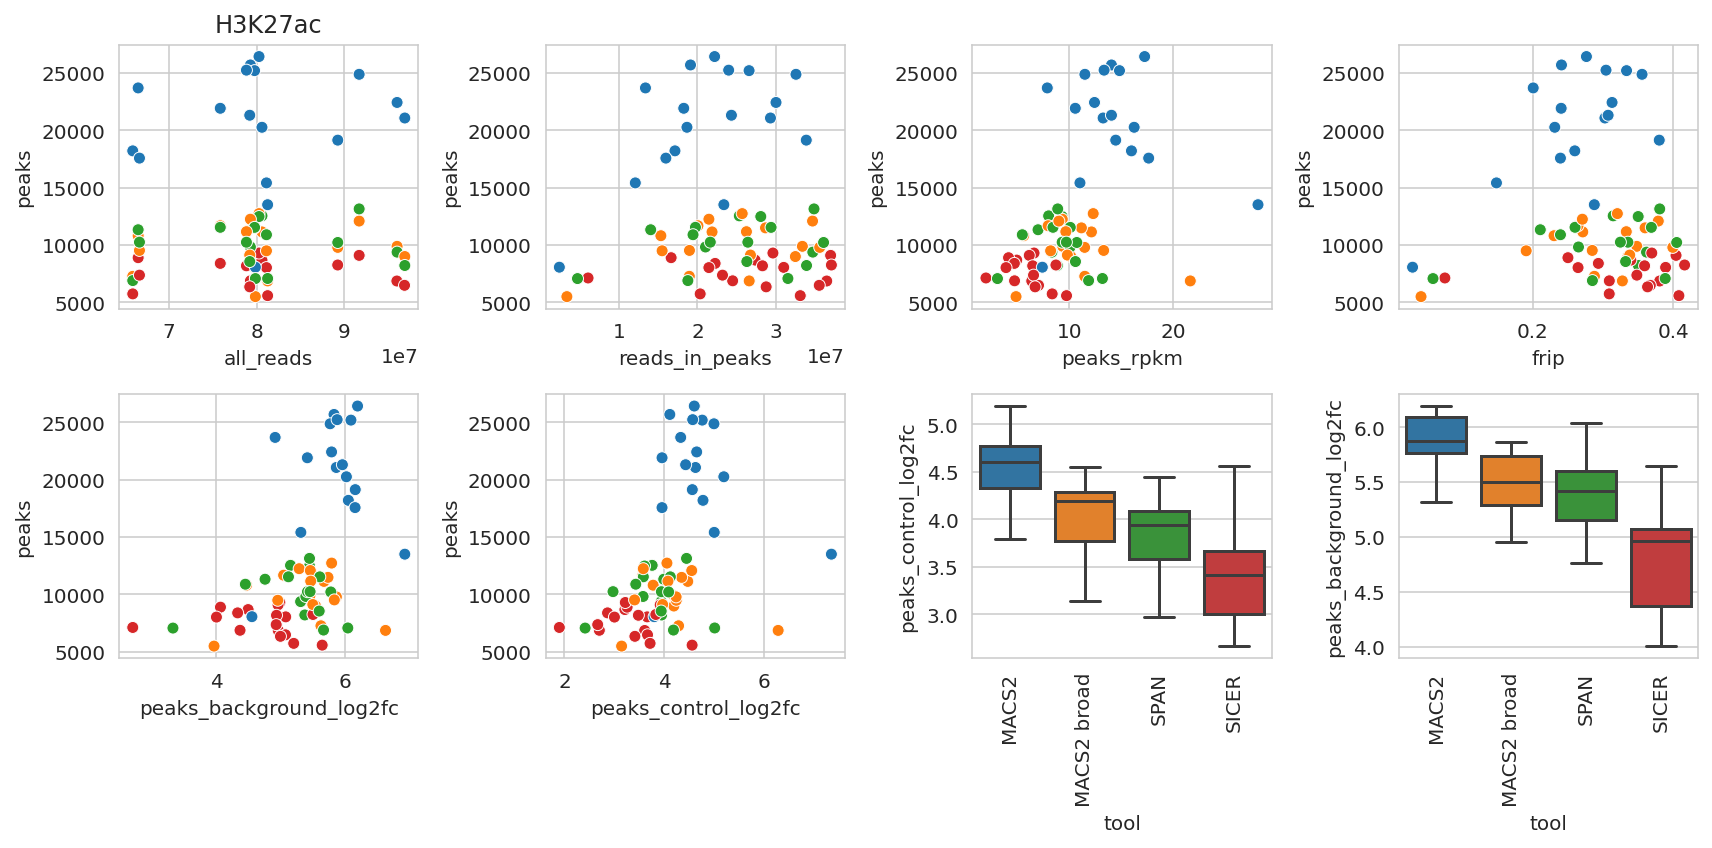

In [119]:
import seaborn as sns

t = frip_df

plt.figure(figsize=(12, 6))
axs = [plt.subplot(2, 4, i + 1) for i in range(8)]
ax = axs[0]
ax.set_title('H3K27ac')
g_results = sns.scatterplot(data=t, x='all_reads', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[1]
g_results = sns.scatterplot(data=t, x='reads_in_peaks', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[2]
g_results = sns.scatterplot(data=t, x='peaks_rpkm', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[3]
g_results = sns.scatterplot(data=t, x='frip', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[4]
g_results = sns.scatterplot(data=t, x='peaks_background_log2fc', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[5]
g_results = sns.scatterplot(data=t, x='peaks_control_log2fc', y='peaks', hue='tool',
                            palette=TOOLS_PALETTE, ax=ax)
g_results.axes.legend().set_visible(False)

ax = axs[6]
g_results = sns.boxplot(data=t, x='tool', y='peaks_control_log2fc',
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        showfliers=False,
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# g_results.axes.legend().set_visible(False)


ax = axs[7]
g_results = sns.boxplot(data=t, x='tool', y='peaks_background_log2fc',
                        palette=TOOLS_PALETTE,
                        order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                        showfliers=False,
                        ax=ax)
ax.xaxis.set_tick_params(rotation=90)
# g_results.axes.legend().set_visible(False)
# Put a legend to the right of the current axis
# g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

plt.show()

## Peaks Density

In [120]:
import pyBigWig
import tempfile
from itertools import product

tf = tempfile.mktemp()

coverage_data = []

for c, r in tqdm(product(GSE26320_CELLS, GSE26320_REPS)):
    print(c, r)
    t = bws_df[(bws_df['modification'] == 'H3K27ac') &
               (bws_df['cell'] == c) &
               (bws_df['replicate'] == r)]
    if len(t) == 0:
        continue
    bw_file = t['file'].values[0]
    t = bws_control_df[(bws_control_df['cell'] == c) & (bws_control_df['replicate'] == r)]
    if len(t) == 0:
        continue
    bw_control_file = t['file'].values[0]
    for tool in set(df_fdr_peaks['tool']):
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        if lines(peaks_file) > 0:
            t = pd.read_csv(peaks_file, sep='\t', header=None)
            positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            with pyBigWig.open(bw_file) as bw:
                total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K27ac', c, r, tool, pos, length, 'treatment', peak_coverage, total_coverage))
            with pyBigWig.open(bw_control_file) as bwc:
                total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                  for chr, start, end in zip(t[0], t[1], t[2])]
            for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                coverage_data.append(('H3K27ac', c, r, tool, pos, length, 'control', peak_coverage, total_coverage))
        if tool == 'SPAN':
            span_file = peaks_file

    # Processing single tools information
    for tool in TOOLS:
        if tool == 'SPAN':
            continue
        t = df_fdr_peaks[(df_fdr_peaks['tool'] == tool) &
                         (df_fdr_peaks['modification'] == 'H3K27ac') &
                         (df_fdr_peaks['cell'] == c) &
                         (df_fdr_peaks['replicate'] == r)]
        if len(t) == 0:
            continue
        peaks_file = sorted_file(t['file'].values[0])
        for name, args in [
            (f'SPAN - {tool}', f' -a {span_file} -b {peaks_file} '),
            (f'{tool} - SPAN', f' -b {span_file} -a {peaks_file} ')
        ]:
            !bedtools intersect {args} -wa -v > {tf}
            if lines(tf) > 0:
                t = pd.read_csv(tf, sep='\t', header=None)
                positions = [f'{chr}:{start}-{end}' for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                lengths = [end - start for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                with pyBigWig.open(bw_file) as bw:
                    total_coverage = sum(bw.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique() if chr in CHROM_SIZES)
                    peaks_coverage = [bw.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2]) if chr in CHROM_SIZES]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K27ac', c, r, name, pos, length, 'treatment', peak_coverage, total_coverage))
                with pyBigWig.open(bw_control_file) as bwc:
                    total_coverage = sum(bwc.stats(chr, type='sum', exact=True)[0] for chr in t[0].unique())
                    peaks_coverage = [bwc.stats(chr, start, end, type='sum', exact=True)[0]
                                      for chr, start, end in zip(t[0], t[1], t[2])]
                for pos, length, peak_coverage in zip(positions, lengths, peaks_coverage):
                    coverage_data.append(('H3K27ac', c, r, name, pos, length, 'control', peak_coverage, total_coverage))

df_coverage = pd.DataFrame(
    coverage_data,
    columns=['modification', 'cell', 'replicate', 'name', 'position', 'length', 'type', 'coverage', 'total_coverage']
)
del coverage_data
df_coverage.sample(5)

0it [00:00, ?it/s]

GM12878 rep1
GM12878 rep2
HMEC rep1
HMEC rep2
HSMM rep1
HSMM rep2
K562 rep1
K562 rep2
NHEK rep1
NHEK rep2
NHLF rep1
NHLF rep2
H1 rep1
H1 rep2
Huvec rep1
Huvec rep2
HepG2 rep1
HepG2 rep2


,modification,cell,replicate,name,position,length,type,coverage,total_coverage
1288571,H3K27ac,NHLF,rep2,MACS2,chr4:141411136-141411665,529,control,0.000000,8.171395e+07
502629,H3K27ac,HSMM,rep1,MACS2,chr20:51339313-51339674,361,control,4.653125,8.314623e+07
896929,H3K27ac,NHEK,rep1,SICER,chr5:149630400-149637799,7399,treatment,13564.111749,9.169253e+07
158711,H3K27ac,GM12878,rep2,MACS2,chr14:22524463-22524699,236,control,24.865831,9.839026e+07
193559,H3K27ac,HMEC,rep1,MACS2 broad,chr1:18926505-18927445,940,treatment,935.494204,8.061657e+07


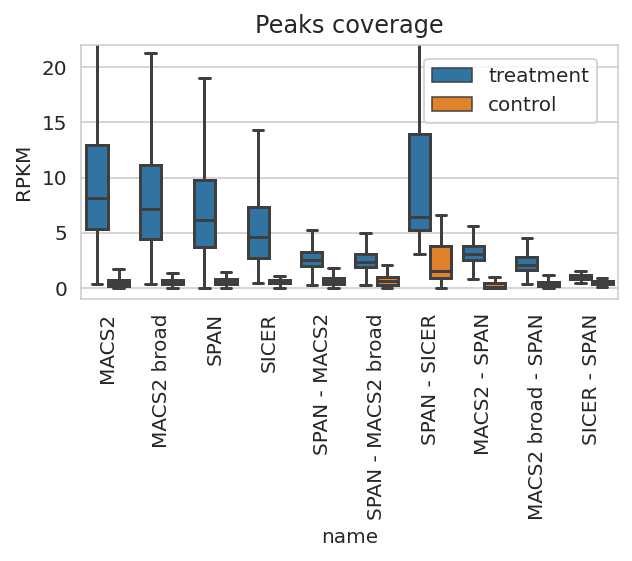

In [121]:
df_coverage['rpm'] = df_coverage['coverage'] / (df_coverage['total_coverage'] / 1e6)
df_coverage['rpkm'] = df_coverage['rpm'] / (df_coverage['length'] / 1e3)

plt.figure(figsize=(4.5, 4))
g_results = sns.boxplot(data=df_coverage, x='name', y='rpkm', hue='type',
                        order=['MACS2', 'MACS2 broad',  'SPAN', 'SICER',
                               'SPAN - MACS2', 'SPAN - MACS2 broad', 'SPAN - SICER',
                               'MACS2 - SPAN', 'MACS2 broad - SPAN', 'SICER - SPAN',
                               ],
                        showfliers=False)
ax = g_results.axes
ax.xaxis.set_tick_params(rotation=90)
ax.set_ylabel('RPKM')
ax.set_ylim(-1, 22)
# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(0.62, 0.82))
plt.title('Peaks coverage')
plt.tight_layout()
plt.show()

# Wiggle bed files

In [218]:
WD = os.path.expanduser('~/data/2023_GSE26320_wiggle_80_100')

percentile_file = f'{WD}/80%-100%_H3K27ac_GM12878_rep1.bed'
bed = f'{WD}/GSM646316_GM12878_H3K27ac_rep1.bed'
tf1 = tempfile.mktemp()
tf2 = tempfile.mktemp()
! bedtools intersect -a {sorted_file(bed)} -b {sorted_file(percentile_file)} -wa > {tf1}
! bedtools intersect -a {sorted_file(bed)} -b {sorted_file(percentile_file)} -wa -v > {tf2}
tf1_len, tf2_len = lines(tf1), lines(tf2)
print('Overlapping', tf1_len, 'Non-onverlapping', tf2_len)

Overlapping 2725496 Non-onverlapping 4323562


In [219]:
t = pd.read_csv(tf1, sep='\t', header=None)
t.sample(5)

,0,1,2,3,4,5
329813,chr10,75611402,75611453,SRR094196.22813952,42,+
1853067,chr3,178547650,178547701,SRR094196.3155334,42,+
2261372,chr6,109381598,109381649,SRR094196.24291985,42,+
2412989,chr7,128934436,128934487,SRR094196.22942536,42,-
381172,chr10,119539091,119539142,SRR094196.12664588,42,-


In [220]:
# Wiggle signal in 80-100% area 
signal = t.sample(int(len(t) * 0.3))
noise = t.sample(int(len(t) * 0.3))
delta = [int(x) for x in np.random.normal(0, 5_000, size=len(noise))]
noise[1] += delta
noise[2] += delta
noise.loc[noise[1] < 1, 1] = 1
noise.loc[noise[2] < 1, 2] = 1

In [221]:
t = pd.concat([signal, noise]).reset_index(drop=True)
t.to_csv(tf1, sep='\t', index=False, header=None)

In [222]:
result_file = f'{WD}/GSM646316_GM12878_H3K27ac_rep1_wiggle.bed'
! cat {tf1} > {result_file}
! cat {tf2} >> {result_file}

In [223]:
del t

# Mixing with input

In [212]:
signal = pd.read_csv(bed, sep='\t', header=None)
reads = len(signal)
signal.sample(5)

,0,1,2,3,4,5
4967056,chrX,98496758,98496809,SRR094196.14496137,42,+
6566115,chr2,43294410,43294461,SRR094196.22768308,42,-
4677108,chr12,92362186,92362237,SRR094196.23497615,42,+
6388616,chr11,108223221,108223272,SRR094196.10583406,40,+
1855591,chr15,75860152,75860203,SRR094196.14750767,34,-


In [215]:
input = f'{WD}/GSM646332_GM12878_Input_rep1.bed'
noise = pd.read_csv(input, sep='\t', header=None)
noise.sample(5)

,0,1,2,3,4,5
2502031,chr10,129709761,129709812,SRR094215.501364,42,-
3923087,chrX,40392730,40392781,SRR094215.6784480,42,+
1444216,chr15,39771637,39771688,SRR094215.1565761,42,+
3064332,chr5,25165998,25166049,SRR094215.2383229,42,+
15871,chr18,7706739,7706790,SRR094215.1113520,42,+


In [216]:
signal = signal.sample(int(reads * 0.5))
noise = noise.sample(int(reads * 0.5))
signal.to_csv(tf1, sep='\t', index=False, header=None)
noise.to_csv(tf2, sep='\t', index=False, header=None)
result_file = f'{WD}/GSM646316_GM12878_H3K27ac_rep1_mix.bed'
! cat {tf1} > {result_file}
! cat {tf2} >> {result_file}

In [217]:
del signal, noise

# Lengths distribution in noise conditions

In [247]:
df_fdr_macs2 = load_peaks_fdr(os.path.join(WD, 'macs2'), '.narrowPeak', ['0.05'])
df_fdr_macs2['tool'] = 'MACS2'
print('MACS2', len(df_fdr_macs2))

df_fdr_macs2broad = load_peaks_fdr(os.path.join(WD, 'macs2'), '.broadPeak', ['0.1'])
df_fdr_macs2broad['tool'] = 'MACS2 broad'
print('MACS2 broad', len(df_fdr_macs2broad))

df_fdr_sicer = load_peaks_fdr(os.path.join(WD, 'sicer'), 'summary-FDR', ['0.01'])
# df_fdr_sicer = load_peaks_fdr(os.path.join(GSE26320_PATH_HG38, 'sicer'), '.scoreisland', ['0.01'])
df_fdr_sicer['tool'] = 'SICER'
print('SICER', len(df_fdr_sicer))

df_fdr_span = load_peaks_fdr(os.path.join(WD, 'span'), '.peak', ['0.05'])
df_fdr_span['tool'] = 'SPAN'
print('SPAN', len(df_fdr_span))

df_fdr_peaks = pd.concat([df_fdr_macs2, df_fdr_macs2broad, df_fdr_sicer, df_fdr_span])
df_fdr_peaks['name'] = df_fdr_peaks['tool'] 
df_fdr_peaks['type'] = 'base'
mix_rows = ['mix' in os.path.basename(f) for f in df_fdr_peaks['file']]
wiggle_rows = ['wiggle' in os.path.basename(f) for f in df_fdr_peaks['file']]
df_fdr_peaks.loc[mix_rows, 'name'] = df_fdr_peaks[mix_rows]['name'] + ' mix'
df_fdr_peaks.loc[mix_rows, 'type'] = 'mix'
df_fdr_peaks.loc[wiggle_rows, 'name'] = df_fdr_peaks[wiggle_rows]['name'] + ' wiggle'
df_fdr_peaks.loc[wiggle_rows, 'type'] = 'wiggle'
df_fdr_peaks

  0%|          | 0/24 [00:00<?, ?it/s]

MACS2 3


  0%|          | 0/24 [00:00<?, ?it/s]

MACS2 broad 3


  0%|          | 0/3 [00:00<?, ?it/s]

SICER 3


  0%|          | 0/6 [00:00<?, ?it/s]

SPAN 3


,file,modification,cell,replicate,fdr,peaks,avlength,tool,name,type
0,/home/jetbrains/data/2023_GSE26320_wiggle_80_1...,H3K27ac,GM12878,rep1,0.05,30081,680.727070,MACS2,MACS2 mix,mix
1,/home/jetbrains/data/2023_GSE26320_wiggle_80_1...,H3K27ac,GM12878,rep1,0.05,47290,885.814401,MACS2,MACS2,base
2,/home/jetbrains/data/2023_GSE26320_wiggle_80_1...,H3K27ac,GM12878,rep1,0.05,48631,810.532520,MACS2,MACS2 wiggle,wiggle
0,/home/jetbrains/data/2023_GSE26320_wiggle_80_1...,H3K27ac,GM12878,rep1,0.1,28013,958.934673,MACS2 broad,MACS2 broad mix,mix
1,/home/jetbrains/data/2023_GSE26320_wiggle_80_1...,H3K27ac,GM12878,rep1,0.1,44829,1113.934886,MACS2 broad,MACS2 broad wiggle,wiggle
2,/home/jetbrains/data/2023_GSE26320_wiggle_80_1...,H3K27ac,GM12878,rep1,0.1,31476,2079.336892,MACS2 broad,MACS2 broad,base
0,/home/jetbrains/data/2023_GSE26320_wiggle_80_1...,H3K27ac,GM12878,rep1,0.01,25610,3788.582194,SICER,SICER mix,mix
1,/home/jetbrains/data/2023_GSE26320_wiggle_80_1...,H3K27ac,GM12878,rep1,0.01,32861,3777.138219,SICER,SICER,base
2,/home/jetbrains/data/2023_GSE26320_wiggle_80_1...,H3K27ac,GM12878,rep1,0.01,36151,4065.111588,SICER,SICER wiggle,wiggle
0,/home/jetbrains/data/2023_GSE26320_wiggle_80_1...,H3K27ac,GM12878,rep1,0.05,34592,3337.310216,SPAN,SPAN wiggle,wiggle


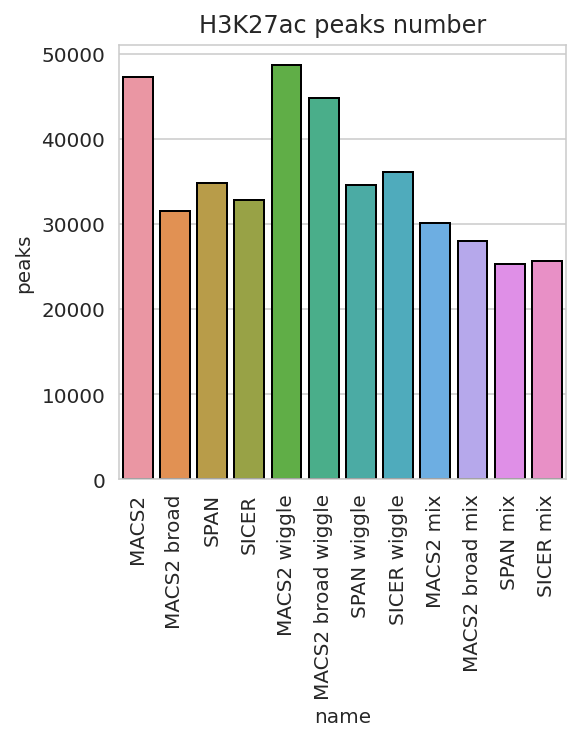

In [251]:
order = [f'{tool}{suffix}' for (suffix, tool) in product(['', ' wiggle', ' mix'], ['MACS2', 'MACS2 broad', 'SPAN', 'SICER'])]

plt.figure(figsize=(4, 4))
ax = plt.axes()
g_results = sns.barplot(data=df_fdr_peaks, x='name', y='peaks', ax=ax,
                        capsize=.2, errwidth=2, edgecolor="black",
                        order=order)
ax.xaxis.set_tick_params(rotation=90)
ax.title.set_text('H3K27ac peaks number')
plt.show()

In [252]:
df_fdr_peaks['type']

0       mix
1      base
2    wiggle
0       mix
1    wiggle
2      base
0       mix
1      base
2    wiggle
0    wiggle
1       mix
2      base
Name: type, dtype: object

# Difference between broad and narrow peaks

In [253]:
! mkdir -p {WD}/union

perc_len_dfs = []
perc_peaks_df = pd.DataFrame(columns=['type', 'length', 'tool', 'peaks'], dtype=object)

for ty in tqdm(df_fdr_peaks['type'].unique()):
    tf = tempfile.mktemp()

    print(ty)
    t = df_fdr_peaks[(df_fdr_peaks['modification'] == 'H3K27ac') &
                     (df_fdr_peaks['type'] == ty)]
    if len(t) == 0:
        continue
    try:
        t_span = sorted_file(t[t['tool'] == 'SPAN']['file'].values[0])
        t_macs2 = sorted_file(t[t['tool'] == 'MACS2']['file'].values[0])
        t_macs2broad = sorted_file(t[t['tool'] == 'MACS2 broad']['file'].values[0])
        t_sicer = sorted_file(t[t['tool'] == 'SICER']['file'].values[0])
        # Prepare total overlap
        union_path = f'{WD}/union/H3K27ac_{ty}.bed'
        ! bedtools multiinter -i {t_span} {t_macs2} {t_macs2broad} {t_sicer} > {tf}
        ! bedtools merge -i {tf} > {union_path}
        t = pd.read_csv(union_path, sep='\t', header=None, usecols=[0, 1, 2])
        t[3] = t[2] - t[1]
        t.sort_values(by=[3, 0, 1, 2], inplace=True)
        # Take % peaks by lengths and compute ratios inside
        step = 20
        for percentage in [0, 20, 40, 60, 80]:
            percentage_name = f'{percentage}%-{percentage + step}%'
            t.iloc[int(len(t) * percentage / 100):int(len(t) * (percentage + step) / 100)][[0, 1, 2]].to_csv(
                tf, sep='\t', index=False, header=None
            )
            for tool, file in [('MACS2', t_macs2), ('MACS2 broad', t_macs2broad), ('SPAN', t_span), ('SICER', t_sicer)]:
                # Prepare tool percentage peaks
                ! bedtools intersect -wa -u -a {file} -b {sorted_file(tf)} > {file}-perc
                # print(tool)
                # ! wc -l {file}-perc
                peak_lengths = bedl(f'{file}-perc')
                tl = pd.DataFrame(dict(peak_lengths=peak_lengths))
                tl['name'] = tool
                tl['type'] = ty
                tl['length'] = percentage_name
                perc_peaks_df.loc[len(perc_peaks_df)] = (ty, percentage_name, tool, len(peak_lengths))
                perc_len_dfs.append(tl.sample(min(len(tl), 10_000)))

    except Exception as e:
        print(e)

display(perc_peaks_df.sample(3))
perc_len_df = pd.concat(perc_len_dfs).reset_index(drop=True)
del perc_len_dfs
display(perc_len_df.sample(3))

  0%|          | 0/3 [00:00<?, ?it/s]

mix
base
wiggle


,type,length,tool,peaks
11,mix,40%-60%,SICER,5255
37,base,80%-100%,MACS2 broad,9876
40,wiggle,0%-20%,MACS2,2792


,peak_lengths,name,type,length
57188,1199,MACS2 broad,mix,60%-80%
125642,931,MACS2,base,20%-40%
286543,1053,MACS2 broad,wiggle,40%-60%


base
wiggle
mix


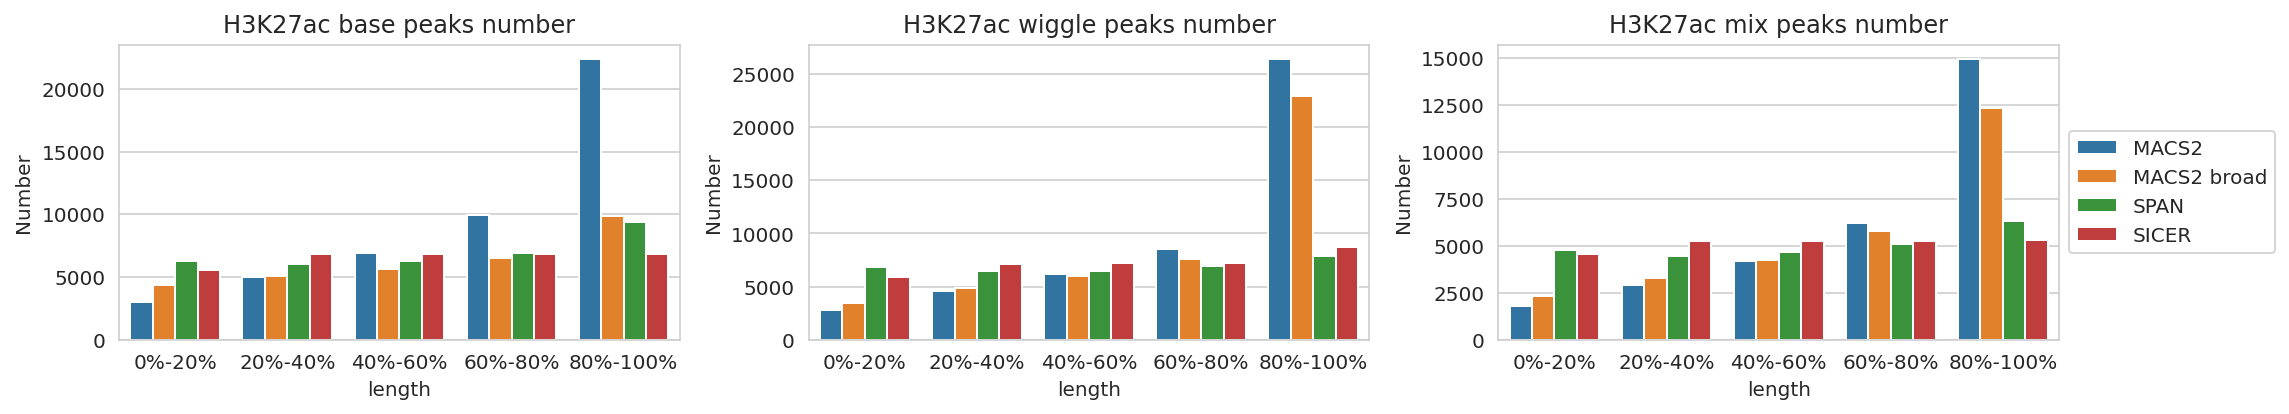

In [270]:
plt.figure(figsize=(16, 3))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]


for i, ty in enumerate(['base', 'wiggle', 'mix']):
    tf = tempfile.mktemp()

    print(ty)
    ax = axs[i]
    g_results = sns.barplot(data=perc_peaks_df[perc_peaks_df['type'] == ty],
                            y='peaks', x='length', ax=ax,
                            hue='tool',
                            hue_order=['MACS2', 'MACS2 broad', 'SPAN', 'SICER'],
                            palette=TOOLS_PALETTE,
                            )
    ax.title.set_text(f'H3K27ac {ty} peaks number')
    g_results.axes.set_ylabel('Number')
    ax.set_ylim(0, 27_000)
    if i != 2:
        ax.legend().set_visible(False)
    else:
        # Put a legend to the right of the current axis
        g_results.axes.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

base
wiggle
mix


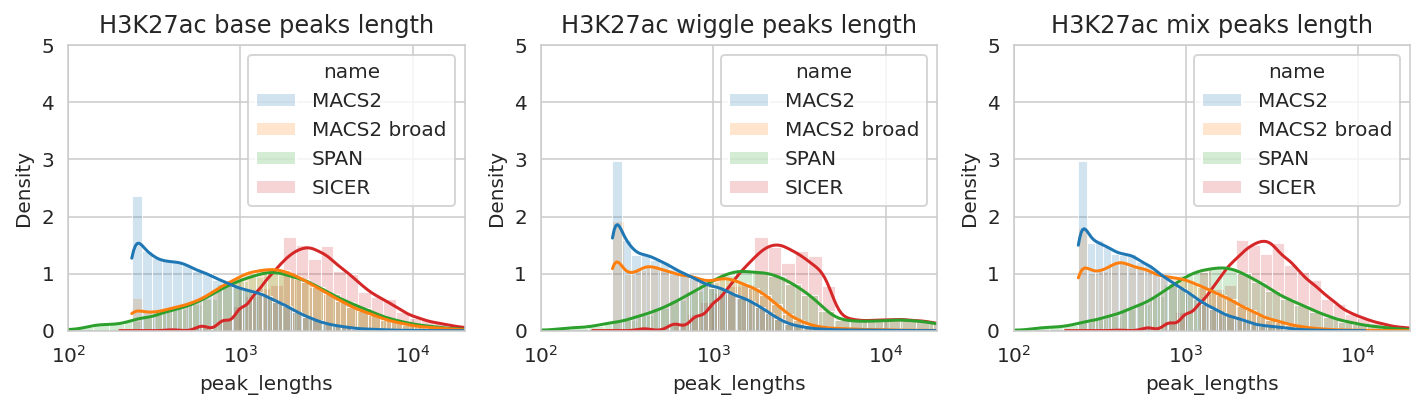

In [274]:
plt.figure(figsize=(10, 3))
axs = [plt.subplot(1, 3, i + 1) for i in range(3)]

for i, ty in enumerate(['base', 'wiggle', 'mix']):
    tf = tempfile.mktemp()
    print(ty)
    ax = axs[i]
    g_results = sns.histplot(data=perc_len_df[perc_len_df['type'] == ty], x='peak_lengths', hue='name', ax=ax,
                             stat='density', common_bins=False, common_norm=False,
                             bins=35, kde=True, log_scale=True, alpha=0.2,
                             palette=TOOLS_PALETTE,
                             hue_order=TOOLS)
    g_results.set(xscale='log')
    g_results.set_ylim(0, 5)
    g_results.set_xlim(1e2, 2e4)
    ax.title.set_text(f'H3K27ac {ty} peaks length')

plt.tight_layout()
plt.show()

# Compare Jaccard between MACS2 broad and SPAN

In [331]:
import tempfile
from itertools import product

perc_reps_overlap = pd.DataFrame(
    columns=['tool', 'length_percentage',
             'peaks1', 'peaks1_len', 'peaks2', 'peaks2_len',
             'peaks1_overlap', 'peaks1_overlap_len',
             'peaks2_overlap', 'peaks2_overlap_len'], dtype=object)

rep1_macs = f'{GSE26320_PATH_HG38}/macs2/GSM646316_GM12878_H3K27ac_rep1_broad0.1_peaks.broadPeak'
rep2_macs = f'{GSE26320_PATH_HG38}/macs2/GSM646317_GM12878_H3K27ac_rep2_broad0.1_peaks.broadPeak'
rep1_span = f'{GSE26320_PATH_HG38}/span/GSM646316_GM12878_H3K27ac_rep1_100_0.05_3.peak'
rep2_span = f'{GSE26320_PATH_HG38}/span/GSM646317_GM12878_H3K27ac_rep2_100_0.05_3.peak'

tf = tempfile.mktemp()
!bedtools intersect -a {sorted_file(rep1_macs)} -b {sorted_file(rep2_macs)} -wo > {tf}
t = pd.read_csv(tf, sep='\t', header=None)
# display(t.sample(3))
t['l1'] = t[2] - t[1]
t['l2'] = t[11] - t[10]
t['o'] = t[18]
t['name'] = 'MACS2'
to_macs2 = t[['name', 'l1', 'l2', 'o']].copy()
tl_macs2 = pd.concat([t[10] - t[1], t[11] - t[2]]).reset_index(drop=True)
tl_macs2 = pd.DataFrame(dict(diff=tl_macs2))
tl_macs2['name'] = 'MACS2'
# display(tl_macs2.sample(3))
!bedtools intersect -a {sorted_file(rep1_span)} -b {sorted_file(rep2_span)} -wo > {tf}
t = pd.read_csv(tf, sep='\t', header=None)
# display(t.sample(3))
t['l1'] = t[2] - t[1]
t['l2'] = t[11] - t[10]
t['o'] = t[18]
t['name'] = 'SPAN'
to_span = t[['name', 'l1', 'l2', 'o']].copy()
tl_span = pd.concat([t[10] - t[1], t[11] - t[2]]).reset_index(drop=True)
tl_span = pd.DataFrame(dict(diff=tl_span))
tl_span['name'] = 'SPAN'
# display(tl_span.sample(3))
tl = pd.concat([tl_macs2, tl_span]).reset_index(drop=True)
to = pd.concat([to_macs2, to_span]).reset_index(drop=True)
display(tl.sample(3))
display(to.sample(3))

,diff,name
99916,116,SPAN
67694,-402,SPAN
44238,-246,MACS2


,name,l1,l2,o
37275,SPAN,3201,3144,2961
32246,SPAN,1558,1383,1374
15103,MACS2,4616,2618,2618


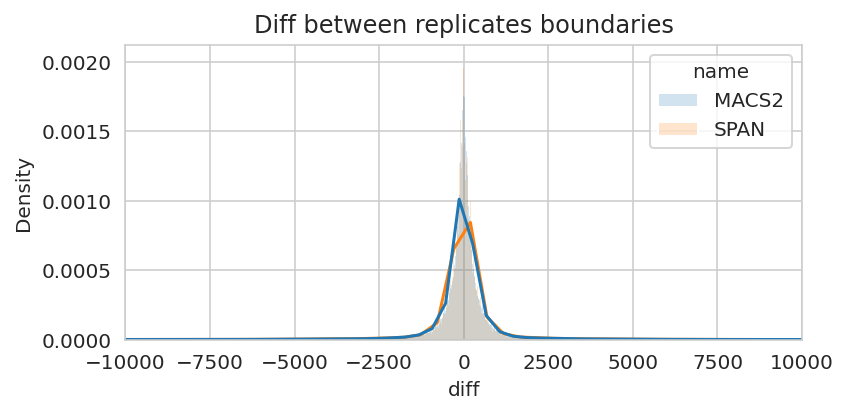

In [332]:
plt.figure(figsize=(6, 3))
g_results = sns.histplot(data=tl, x='diff', hue='name',
                         stat='density', common_bins=False, common_norm=False,
                         kde=True, alpha=0.2)
g_results.set_xlim(-10_000, 10_000)
g_results.axes.title.set_text(f'Diff between replicates boundaries')

plt.tight_layout()
plt.show()

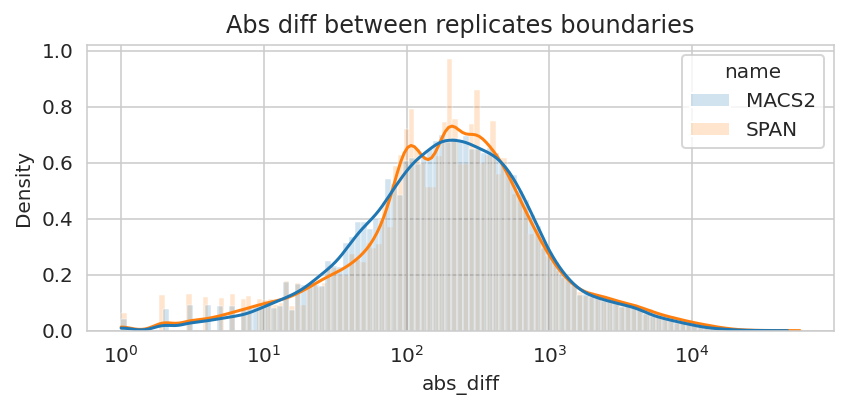

In [333]:
tl['abs_diff'] = np.fabs(tl['diff']) + 1
plt.figure(figsize=(6, 3))
g_results = sns.histplot(data=tl, x='abs_diff', hue='name',
                         stat='density', common_bins=False, common_norm=False,
                         kde=True, log_scale=True, alpha=0.2)
g_results.set(xscale='log')
g_results.axes.title.set_text(f'Abs diff between replicates boundaries')

plt.tight_layout()
plt.show()

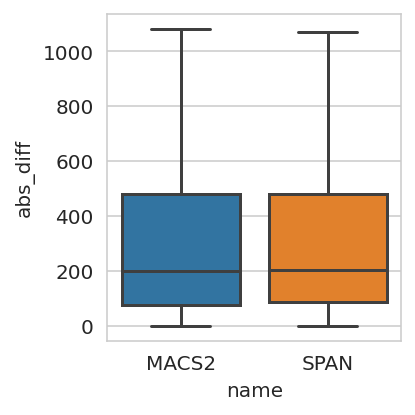

In [334]:
plt.figure(figsize=(3, 3))
g_results = sns.boxplot(data=tl, x='name', y='abs_diff', showfliers=False)
plt.tight_layout()
plt.show()

In [336]:
to['jaccard'] = [d(o, l1 + l2 - o) for o, l1, l2 in zip(to['o'], to['l1'], to['l2'])]

,name,l1,l2,o,jaccard
0,MACS2,1334,1171,1139,0.833821
1,MACS2,809,1573,809,0.514304
2,MACS2,722,760,672,0.829630
3,MACS2,2545,3031,2545,0.839657
4,MACS2,1681,797,797,0.474123
...,...,...,...,...,...
55051,SPAN,2153,2009,2009,0.933117
55052,SPAN,965,873,771,0.722587
55053,SPAN,2171,1281,1188,0.524735
55054,SPAN,2926,2266,2071,0.663569


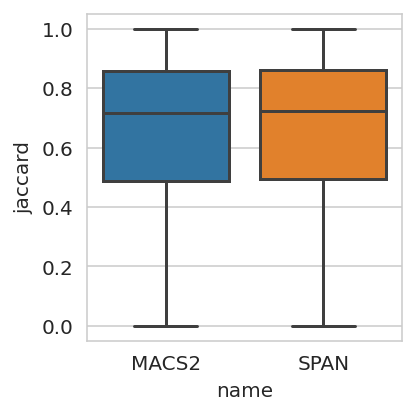

In [337]:
plt.figure(figsize=(3, 3))
g_results = sns.boxplot(data=to, x='name', y='jaccard', showfliers=False)
plt.tight_layout()
plt.show()

In [338]:
for name in ['MACS2', 'SPAN']:
    t = to[to['name'] == name]
    sum_o, sum_u = t['o'].sum(), (t['l1'] + t['l2'] - t['o']).sum()
    print(f'{name} Overlap {sum_o} Union {sum_u} Jaccard {sum_o / sum_u}')

MACS2 Overlap 49907191 Union 77264338 Jaccard 0.6459278923738401
SPAN Overlap 62083430 Union 96718107 Jaccard 0.6419007973346708
